# Marginal 1-dim posteriors from image data

- Using SWYFT core functions (i.e. look at swyft/core.py)
- Demonstrates `head` network

Author: Christoph Weniger and Benjamin Miller, August 2020

In [1]:
import numpy as np
import pylab as plt
import swyft
import torch
from scipy import stats
%load_ext autoreload
%autoreload 2

np.random.seed(25)
torch.manual_seed(25)

In [66]:
DEVICE = 'cuda:0'
NDIM = 8 # number of parameters
NBINS = 1000

In [67]:
SIGMA = 0.2
def model(z):
    x = z
    return x

def noisemodel(x, z = None):
    n = np.random.randn(*x.shape)*SIGMA  #*noiselevel
    return x + n

In [68]:
z0 = np.ones(NDIM)*0.5
x0 = noisemodel(model(z0))

In [69]:
ds = swyft.DataStoreZarr("/home/ubuntu/volume1/high12.zarr")
ds.init(zdim = NDIM, xdim = (NDIM,))

Creating empty datastore: /home/ubuntu/volume1/high12.zarr
...don't forget to run `init` to set up storage parameters.
Datastore initialized.


In [70]:
sw_list = []

for i_round in range(1):
    parent = None if len(sw_list) == 0 else sw_list[-1]
    sw = swyft.SWYFT(x0, zdim = NDIM, device = DEVICE, head = None, datastore = ds, nsamples = 10000, noisemodel = noisemodel, parent = parent)
    sw_list.append(sw)
    
    if sw.requires_sim():
        for i in ds.require_sim():
            z = ds.z[i]
            x = model(z)
            ds.add_sim(i, x)
            
    #sw.train1d(max_epochs = 1, nbatch = 16)

Constrained posterior area: 1.0
Adding 10033 new samples. Run simulator!


In [71]:
plt.figure(figsize=(20, 5))
for i in range(NDIM):
    z, p = sw_list[-1].posterior(i)
    #plt.axvline(x0[i])
    plt.plot(z-x0[i], p)

TypeError: 'NoneType' object is not callable

<Figure size 1440x360 with 0 Axes>

In [72]:
sw.trainNd([list(range(NDIM))], max_epochs = 100, nbatch = 16, tag = 'd1')

Start training
LR iteration 0
Total epochs: 4
Validation losses: [0.4804124999791384, 0.5405274070799351, 0.5152245522476733, 0.5023384282831103]
LR iteration 1
Total epochs: 10
Validation losses: [0.48628196702338755, 0.38230356108397245, 0.5326731591485441, 0.4896435282425955, 0.37618649448268116, 0.44175100832944736, 0.34215486887842417, 0.4322328919079155, 0.4706780625274405, 0.4083876700606197]
LR iteration 2
Total epochs: 9
Validation losses: [0.38644592883065343, 0.3989674965851009, 0.3655177353648469, 0.4198807288194075, 0.37975868582725525, 0.33019225334282964, 0.5423378993291408, 0.4152455271105282, 0.4268861992750317]


In [73]:
z, lnL = sw.posterior(list(range(NDIM)), tag = 'd1')

In [74]:
y = -(((z-x0)/0.2)**2).sum(axis=1)

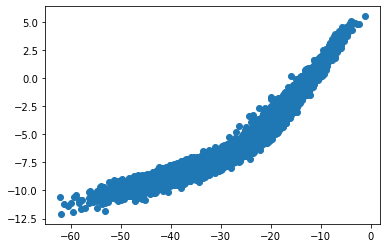

In [77]:
plt.scatter(y, lnL)